# Solving boundary value problems (BVP) and eigenvalue problems (EVP)

**Table of contents**<a id='toc0_'></a>    
1. [BVP in Cartesian coordinates](#toc1_)    
2. [EVP on a disc](#toc2_)    
2.1. [Implementing polar symmetry](#toc2_1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In this notebook, we show how to solve the linear boundary value problems and the linear eigenvalue problems using Trispectral and SciPy.

In [2]:
import os.path
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import trispectral as ts

In [3]:
cwd = os.path.abspath("")

plt.style.use(os.path.join(cwd, "../misc/mpl_styles/main.mplstyle"))

## 1. <a id='toc1_'></a>[BVP in Cartesian coordinates](#toc0_)

Consider the following 2D Laplace equation:

$\nabla^2 u = 0$, for $0\le x \le a$ and $0\le y \le b$,

with the boundary conditions,

$u(0, y) = u(x, 0) = 0$,

$u(a, y) = \sin{(\omega y)} / \sin{(\omega b)}$,

$u(x, b) = \sin{(\omega x)} / \sin{(\omega a)}$.

First, we define the parameters of the problem and the computational grid.

In [1]:
omega = 4.
a = 2.
b = 2.

In [4]:
nx = 61
ny = 61

grid = ts.Grid.from_bounds(
    [0, a, nx], [0, b, ny], discs=["chebyshev"] * 2
)

x, y = grid

Before applying the boundary conditions, the left-hand side and the right-hand side matrices of this problem can be constructed as follows. 

In [5]:
lhs = ts.scalar_laplacian_operator(grid)
rhs = np.zeros(nx * ny)

The `boundary_indices` method of the `Grid` object allows us to immediately obtain the indices of the boundary nodes as they appear in the grid.

In [6]:
bnds = grid.boundary_indices()

xmin, xmax = bnds[0]
ymin, ymax = bnds[1]

In 2D Cartesian geometry, `grid.boundary_indices()` returns the Python list `[(xmin, xmax), (ymin, ymax)]`, where `xmin`, `xmax`, `ymin`, and `ymax` are the NumPy arrays containing the indices of respective boundaries.

We then replace the lines of `lhs` and `rhs` with indices `xmin`, `xmax`, `ymin`, and `ymax` with explicit boundary condition expressions. For example, the line

```python
lhs[xmin] = np.identity(nx * ny)[xmin]
```

results into `ny` linear equations implementing $u(0, y) = 0$ (note that `rhs` is already 0). However, in the case of inhomogeneous Dirichlet conditions, we have to explicitly replace the entries of `rhs`.

In [7]:
lhs[xmin] = np.identity(nx * ny)[xmin] # rhs already 0 at xmin

lhs[xmax] = np.identity(nx * ny)[xmax]
rhs[xmax] = np.sin(omega * y[xmax]) / np.sin(omega * b)

lhs[ymin] = np.identity(nx * ny)[ymin] # rhs already 0 at ymin

lhs[ymax] = np.identity(nx * ny)[ymax]
rhs[ymax] = np.sin(omega * x[ymax]) / np.sin(omega * a)

We then solve the BVP using SciPy's `linalg.solve` and plot the solution.

In [8]:
u = la.solve(lhs, rhs)

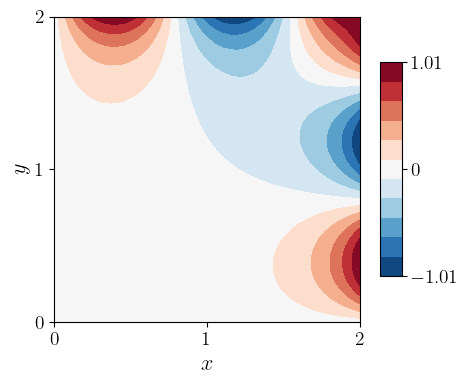

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)

ax.set_aspect(b / a)

ax.set_xlim(0, a)
ax.set_ylim(0, b)

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

c = ax.contourf(
    x.reshape(nx, ny, order="F"),
    y.reshape(nx, ny, order="F"),
    u.reshape(nx, ny, order="F"),
    levels=np.linspace(np.min(u), np.max(u), 12),
    cmap=plt.get_cmap("RdBu_r"),
)

cbar = plt.colorbar(
    c,
    ax=ax,
    ticks=[np.min(u), 0, np.max(u)],
    location="right",
    shrink=0.7,
    aspect=10,
)
cbar.ax.set_yticklabels(
    [
        f"${np.min(u): .2f}$",
        0,
        f"${np.max(u): .2f}$"
    ]
)

ax.set_xticks(np.arange(0, a + 1, 1))
ax.set_yticks(np.arange(0, b + 1, 1));

# plt.savefig("ex_4.pdf");

## 2. <a id='toc2_'></a>[EVP on a disc](#toc0_)

In [9]:
nphi, nr = 64, 64

grid = ts.Grid.polar(nphi, nr)

phi, r = grid[:, grid[1] > 0]

In [10]:
mat = ts.scalar_laplacian_operator(grid, parity=1)

In [11]:
rmax = grid.boundary_indices(axis=1)

mat[rmax] = -1e4 * np.identity(nr * nphi)[rmax]

In [12]:
lam, u = la.eig(-mat)

lam = np.sqrt(lam).real

argsort = lam.argsort()
lam, u = lam[argsort], u.real[:, argsort]

In [13]:
print(lam[:9] / lam[0])

[1.         1.59334051 1.59334051 2.13554879 2.13554879 2.29541727
 2.6530664  2.6530664  2.91729546]


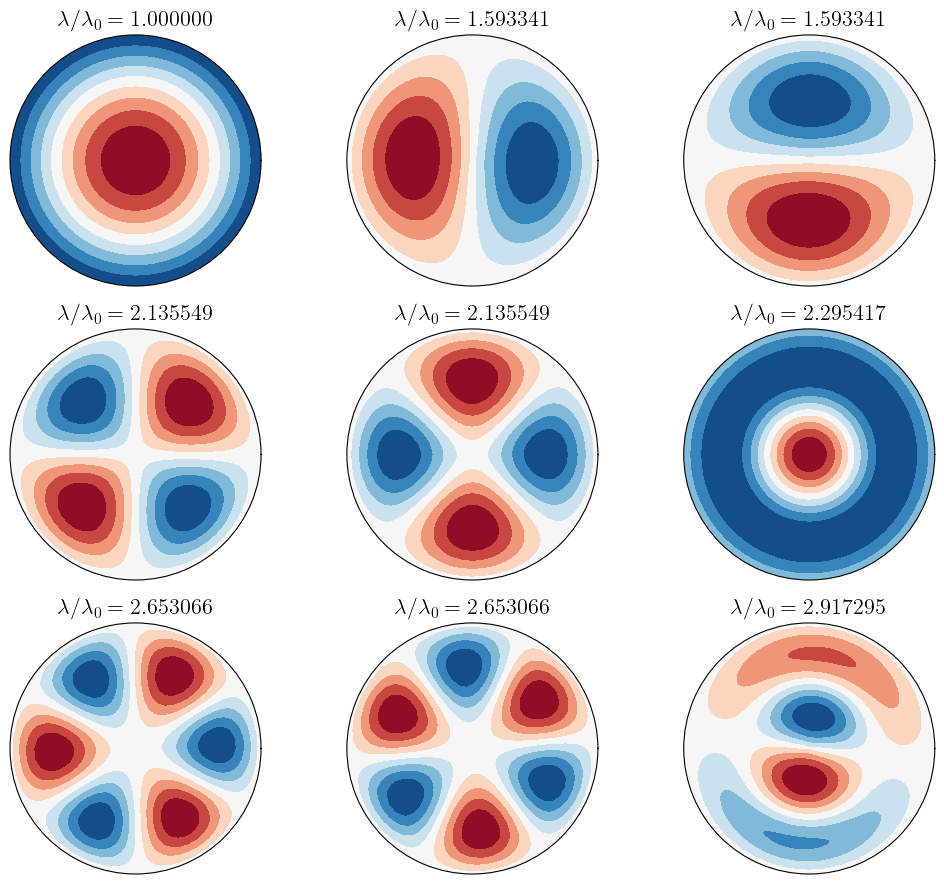

In [14]:
fig, ax = plt.subplots(
    3,
    3,
    figsize=(12, 9),
    subplot_kw={"projection": "polar"},
    tight_layout=True,
)
ax = ax.ravel()

phi_m = phi.reshape(nphi, nr, order="F")
phi_m = np.vstack([phi_m, -phi_m[0]])
r_m = r.reshape(nphi, nr, order="F")
r_m = np.vstack([r_m, r_m[0]])

for i, axis in enumerate(ax):
    axis.grid(False)
    axis.set_xticklabels([])
    axis.set_yticklabels([])

    u_m = u[:, i].reshape(nphi, nr, order="F")
    u_m = np.vstack([u_m, u_m[0]])

    axis.contourf(
        phi_m,
        r_m,
        u_m,
        levels=np.linspace(np.min(u_m), np.max(u_m), 10),
        cmap=plt.get_cmap("RdBu_r"),
    )

    axis.set_title(f"$\\lambda / \\lambda_0 = {lam[i] / lam[0]: .6f}$")

    # plt.savefig("ex_5.pdf");

### 2.1. <a id='toc2_1_'></a>[Implementing polar symmetry](#toc0_)